<a href="https://www.inove.com.ar"><img src="https://raw.githubusercontent.com/InoveAlumnos/dataset_analytics_python/master/images/PA%20Banner.png" width="1000" align="center"></a>


# Segmentación de clientes

Crear un modelo de segmentación para la estimación de los tipos de clientes que van de compras a un shoping<br>
v1.1

In [1]:
import os
import platform

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Recolectar datos
<div align="center"><img src="https://raw.githubusercontent.com/InoveAlumnos/dataset_analytics_python/master/images/Pipeline1.png" width="1000" align="middle"></div>

In [2]:
if os.access('Mall_Customers.csv', os.F_OK) is False:
    if platform.system() == 'Windows':
        !curl https://raw.githubusercontent.com/InoveAlumnos/dataset_analytics_python/master/Mall_Customers.csv > Mall_Customers.csv
    else:
        !wget Mall_Customers.csv https://raw.githubusercontent.com/InoveAlumnos/dataset_analytics_python/master/Mall_Customers.csv

--2023-03-20 19:12:59--  http://mall_customers.csv/
Resolving mall_customers.csv (mall_customers.csv)... failed: Name or service not known.
wget: unable to resolve host address ‘mall_customers.csv’
--2023-03-20 19:12:59--  https://raw.githubusercontent.com/InoveAlumnos/dataset_analytics_python/master/Mall_Customers.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3981 (3.9K) [text/plain]
Saving to: ‘Mall_Customers.csv’

Mall_Customers.csv  100%[===================>]   3.89K  --.-KB/s    in 0s      

2023-03-20 19:12:59 (46.7 MB/s) - ‘Mall_Customers.csv’ saved [3981/3981]

FINISHED --2023-03-20 19:12:59--
Total wall clock time: 0.1s
Downloaded: 1 files, 3.9K in 0s (46.7 MB/s)


### `Mall_Customers.csv`:
El dataset **`Mall_Customers.csv`** contiene datos sobre clientes que asisten al shopping a comprar, y sus características de consumo.<br>
[Dataset source](https://www.kaggle.com/vjchoudhary7/customer-segmentation-tutorial-in-python)
- **CustomerID** --> id del comprador, ejemplo 5
- **Gender** --> género, masculino (Male) o femenino (female)
- **Age** --> edad
- **Annual Income** --> ingreso de dinero anual de la persona en miles de dolares
- **Spending socre** --> que tan gastador es la persona (de 1 a 100)

In [3]:
df = pd.read_csv("Mall_Customers.csv")

# Procesar datos
<div align="center"><img src="https://raw.githubusercontent.com/InoveAlumnos/dataset_analytics_python/master/images/Pipeline2.png" width="1000" align="middle"></div>

In [4]:
# Alumno, inspeccione el dataset, visualice las columnas que posee y sus primeras filas
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [5]:
# Alumno: Los algoritmos de clustering no funcionan bien con las variables categóricas, 
# obtener un nuevo dataset (df2) sin la columna CustomerID y Gender

df2 = df.drop(['CustomerID', 'Gender'], axis=1)
df2.head()

,Age,Annual Income (k$),Spending Score (1-100)
0,19,15,39
1,21,15,81
2,20,16,6
3,23,16,77
4,31,17,40


In [6]:
# Alumno, realice una inspeccion del dataset en búsqueda de elementos faltantes

des = df2.describe()
des.loc['Nan'] = df2.isna().sum()
des.loc['%Nan'] = (df2.isna().mean())*100
des

,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000
mean,38.850000,60.560000,50.200000
std,13.969007,26.264721,25.823522
min,18.000000,15.000000,1.000000
25%,28.750000,41.500000,34.750000
50%,36.000000,61.500000,50.000000
75%,49.000000,78.000000,73.000000
max,70.000000,137.000000,99.000000
Nan,0.000000,0.000000,0.000000
%Nan,0.000000,0.000000,0.000000


In [7]:
# Alumno: ¿Cuántas filas/datos hay para analizar?

print('Cantidad de datos en observacion:', df2.shape[0])

Cantidad de datos en observacion: 200


# Explorar datos
<div align="center"><img src="https://raw.githubusercontent.com/InoveAlumnos/dataset_analytics_python/master/images/Pipeline3.png" width="1000" align="middle"></div>

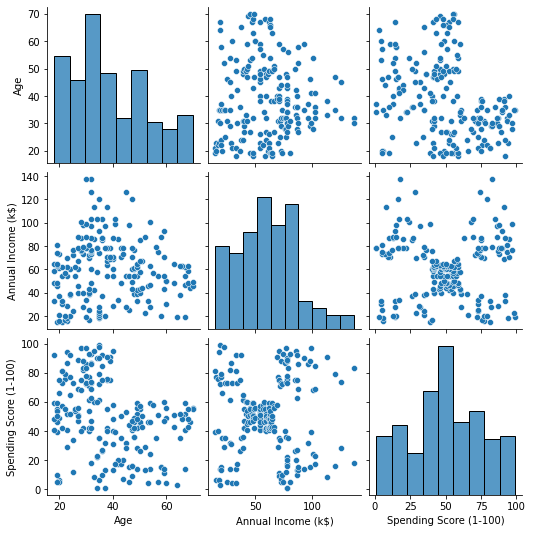

In [8]:
# Observar todas las relaciones entre todos los features, utilizar pairplot
sns.pairplot(df2)
plt.show()
# Se aprecia claramente una relación/agrupamiento entre Annual Income y Spending Score.

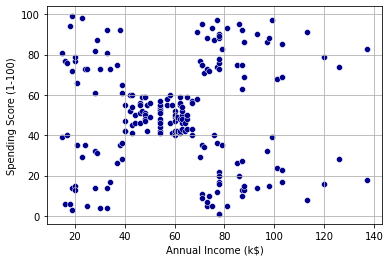

In [11]:
# Alumno: Se puede observar que donde se ve claramente una segmentación de grupos
# en en la relación de "Annual Income" y "Spending Score"
# Graficar unicamente la relación x=Annual Income con y=SpendingScore
# con un scatter plot

fig = plt.figure()
ax = fig.add_subplot()
ax = sns.scatterplot(x=df2["Annual Income (k$)"], y=df2["Spending Score (1-100)"], color="darkBlue", ax=ax)
ax.grid('dashed')
plt.show()

# Entrenar modelo
<div align="center"><img src="https://raw.githubusercontent.com/InoveAlumnos/dataset_analytics_python/master/images/Pipeline4.png" width="1000" align="middle"></div>

In [15]:
# Almuno: Crear un numpy array "X" con los features de entrada (Annual Income y Spending Score)
X = df2.drop("Age", axis=1).values


#### Crear un modelo de segmentación con Kmeans
Parámetros
- n_clusters --> (k) número de clusters/grupos (defecto 5)
- init --> método utilizado para determianr donde comienzan los clusters
 - k-means++ --> mecanismo inteligente para determinar el comienzo (defecto)
 - random --> los centros se determinarn aleatoriamente
- max_iter --> cantidad de iteración (defecto 300)

In [16]:
# Almuno: Entrenar diferentes modelos de Kmeans en un rango de cluster (2, 10)
# Conservar el resultado de "inertial" para utilizar como métrica de selccion


from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def find_best_model(X, max_clusters=10):

    n_clusters = list(range(2, max_clusters+1)) 
    ensayos = len(n_clusters)                  


    array_error = np.zeros((ensayos))
    array_score = np.zeros((ensayos))

    for i in range(ensayos): ## --> ensayos = 9
       
        kmeans = KMeans(n_clusters=n_clusters[i], init="k-means++", random_state=0)
        kmeans.fit(X)
        array_error[i] = kmeans.inertia_
        array_score[i] = silhouette_score(X, kmeans.labels_)

    return array_error, array_score, n_clusters


In [17]:
# Invocamos la función find_best_model, pasándole los valores de X
array_error, array_score, n_clusters = find_best_model(X)

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: F

In [18]:
# Dibujar la evolucion del error (inertia) y deteminar el 
# punto de quiebre (elbow point) para deteminar el mejor k


def graficar_punto_codo(array_error, array_score, n_clusters):
 
  fig = plt.figure()
  ax = fig.add_subplot()

  
  ax.plot(n_clusters, array_error/array_error.max(), label='error') 
  ax.plot(n_clusters, array_score, label='score')
  ax.grid('dashed')
  ax.legend()
  plt.show()

  best_cluster = n_clusters[array_score.argmax()]
  print('El mejor resultado segun la métrica se consigue con clusters=', best_cluster)

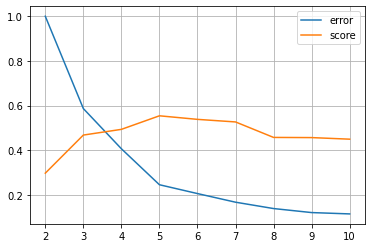

El mejor resultado segun la métrica se consigue con clusters= 5


In [19]:
graficar_punto_codo(array_error, array_score, n_clusters)

In [20]:
# Alumno: Entrenar el modelo con el mejor "K" encontrado
# y determinar los labels

kmeans = KMeans(n_clusters=5, init="k-means++", random_state=0)
kmeans.fit(X)
labels = kmeans.predict(X)

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [25]:
# Alumno: Sumar la columna de labels con el nombre de custseg (customer segmentation)
# a su dataset

df2['cust_seg'] = labels
df2.head()

,Age,Annual Income (k$),Spending Score (1-100),cust_seg
0,19,15,39,4
1,21,15,81,3
2,20,16,6,4
3,23,16,77,3
4,31,17,40,4


# Validar modelo
<img src="https://raw.githubusercontent.com/InoveAlumnos/dataset_analytics_python/master/images/Pipeline5.png" width="1000" align="middle">

In [27]:
# Alumno: Calcular la exactitud (accuracy) del modelo
from sklearn.metrics import silhouette_score
silhouette_score (X, kmeans.labels_)

0.553931997444648

# Utilizar modelo
<img src="https://raw.githubusercontent.com/InoveAlumnos/dataset_analytics_python/master/images/Pipeline6.png" width="1000" align="middle">

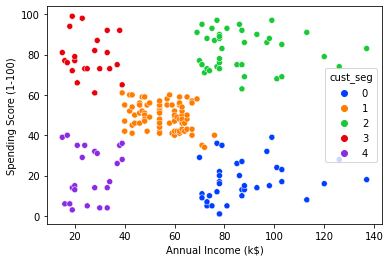

In [29]:
# Alumno: Volver a repetir el gráfico de scatter "Annual Income" y "Spending Socre"
# pero ahora coloreando con "hue" los puntos según su clase de custseg


sns.scatterplot(data=df2, x = "Annual Income (k$)", y= "Spending Score (1-100)", hue='cust_seg', palette='bright')
plt.show()

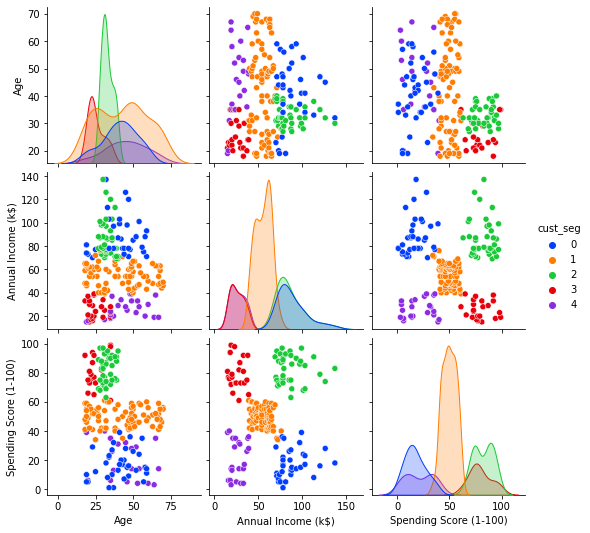

In [30]:
sns.pairplot(df2, hue='cust_seg', palette='bright')
plt.show()